In [1]:
%%bash
# Create da
# Download TF checkpoints in data/models folder

wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
tar -xvzf inception_v3_2016_08_28.tar.gz -C ./data/models/
rm inception_v3_2016_08_28.tar.gz

wget http://download.tensorflow.org/models/adv_inception_v3_2017_08_18.tar.gz
tar -xvzf adv_inception_v3_2017_08_18.tar.gz -C ./data/models/
rm adv_inception_v3_2017_08_18.tar.gz

inception_v3.ckpt
adv_inception_v3.ckpt.data-00000-of-00001
adv_inception_v3.ckpt.index
adv_inception_v3.ckpt.meta


--2018-09-19 23:36:32--  http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.164.112, 2607:f8b0:400a:800::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.164.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100885009 (96M) [application/x-tar]
Saving to: ‘inception_v3_2016_08_28.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  921K 1m47s
    50K .......... .......... .......... .......... ..........  0% 2.09M 76s
   100K .......... .......... .......... .......... ..........  0% 3.39M 60s
   150K .......... .......... .......... .......... ..........  0% 3.84M 52s
   200K .......... .......... .......... .......... ..........  0% 6.60M 44s
   250K .......... .......... .......... .......... ..........  0% 7.29M 39s
   300K .......... .......... .......... .......... ..........  0% 8.71M 35s
   350K .......... .......

In [1]:
# Reference: https://github.com/marcoancona/DeepExplain/blob/master/examples/inception_tensorflow.ipynb
import pandas as pd
import numpy as np
from sklearn import metrics

import tensorflow as tf
from tensorflow.contrib.slim.nets import inception

from skater.util.dataops import json_validator
from skater.util.image_ops import load_image, show_image, normalize, add_noise, flip_pixels, image_transformation
from skater.util.image_ops import in_between, greater_than, greater_than_or_equal 
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter
from skater.core.visualizer.image_relevance_visualizer import visualize, visualize_feature_maps

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


Using TensorFlow backend.


In [2]:
slim = tf.contrib.slim

file_directory = '../../../Skater/build/lib/skater/util/model_specific/imagenet_label.json'
json_data = open(file_directory).read()
json_validator(json_data)

True

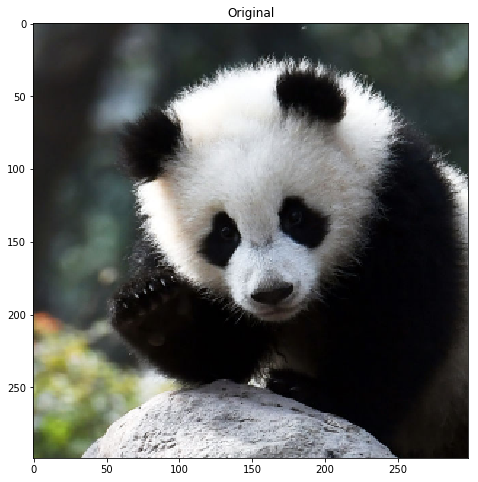

In [3]:
%matplotlib inline
resized_img = load_image('./data/images/pandas.jpg', 299, 299)
input_resized_img = resized_img.reshape((1, 299, 299, 3))
show_image(input_resized_img[0])

In [4]:
# Load Inception V3 model from Tensorflow Slim, restore section
# from checkpoint and run the classifier on the input data
num_classes = 1001

# Select the model here. Use adv_inception_v3 to use the weights of
# an adversarially trained Inception V3. Explanations will be more sparse.

checkpoint = './data/models/inception_v3.ckpt'

In [5]:
# Load the labels related to imagenet dataset
import json
tf.reset_default_graph()
sess = tf.Session()
labels = json.loads(json_data)

In [13]:
tf.reset_default_graph()
sess = tf.Session()
# top k predictions
k = 3
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        net, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    # Compute class probability 
    yi = tf.nn.softmax(logits, 1)
    
    topk, idx = tf.nn.top_k(yi, k=3)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_resized_img
    label_prob, index = sess.run((topk, idx), feed_dict={X: input_X})
    
    # Convert indexes to labels
    label_list = [labels[str(ix)] for ix in index[0]]
    d = {
        'Class Labels ': label_list,
        'Scores' : label_prob.flatten().tolist()
    }
    labels_probabiliy_df = pd.DataFrame(d)

INFO:tensorflow:Restoring parameters from ./data/models/inception_v3.ckpt


In [21]:
from IPython.display import display, HTML
pd.options.display.max_colwidth = 100
display(labels_probabiliy_df)

Class Labels     Scores
0  giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca  0.934644
1                                                        soccer ball  0.001220
2                                                      space shuttle  0.000602

### Querying InceptionV3 by visualizing feature maps per layer

{ 'AuxLogits': <tf.Tensor 'InceptionV3/AuxLogits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
  'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
  'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
  'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
  'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
  'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
  'Logits': <tf.Tensor 'InceptionV3/Logits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
  'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
  'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) d

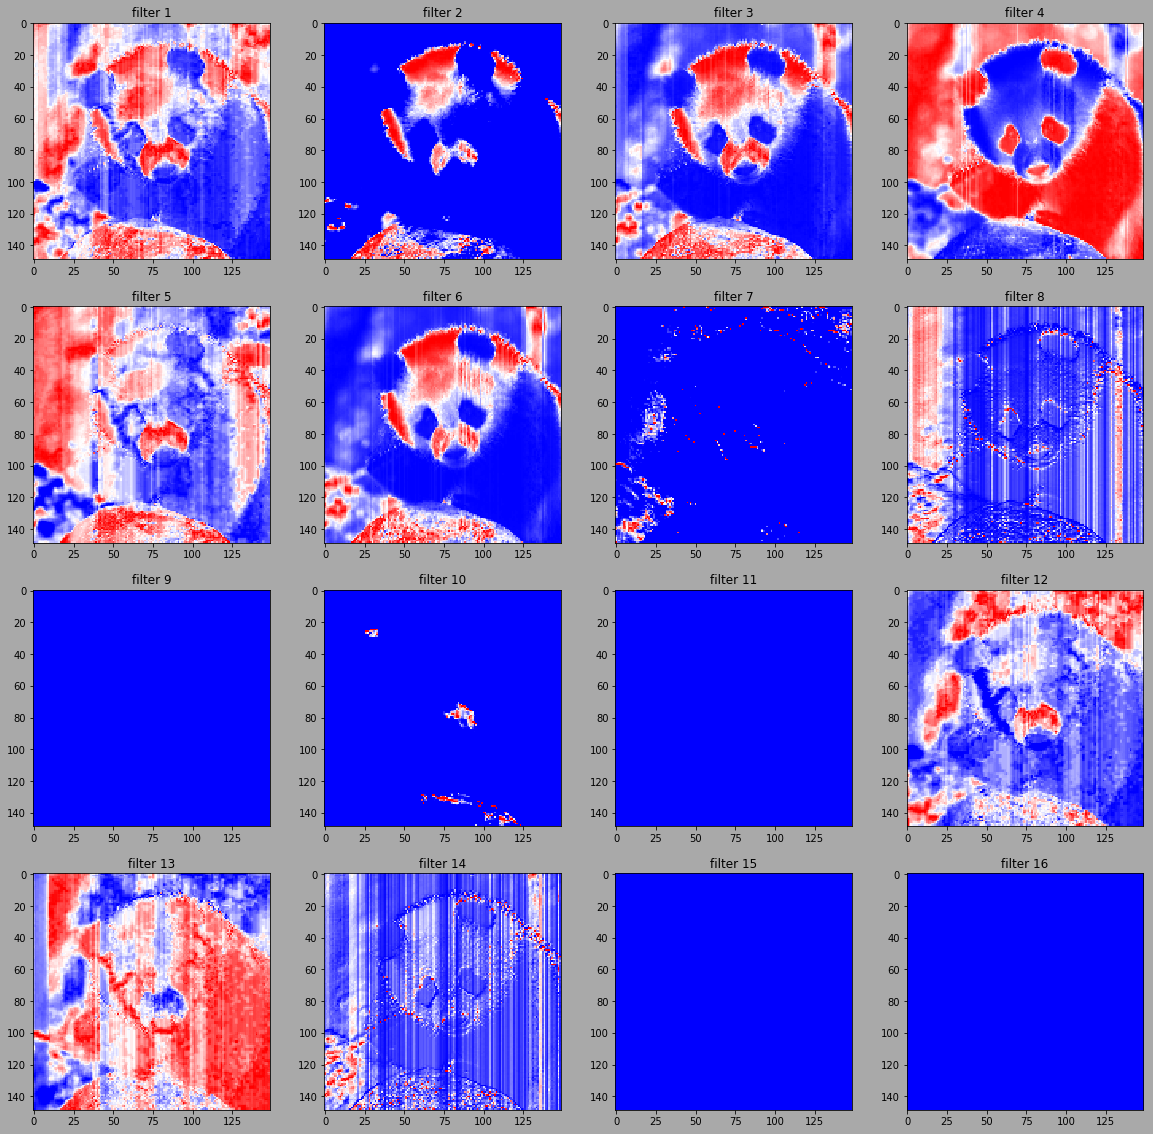

In [18]:
import pprint
tf.reset_default_graph()
sess = tf.Session()
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        net, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)
    pp = pprint.PrettyPrinter(indent=2)
    pp.pprint(end_points)
        
    
    # Check the above cell for other layer names
    logits = end_points['Conv2d_1a_3x3']
    # Compute feature weights
    yi = tf.nn.softmax(logits, 1)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)
    
    input_X = input_resized_img
    fm = sess.run(yi, feed_dict={X: input_X})
    visualize_feature_maps(None, None, precomputed_feature_map=fm[0], n_filters=16)

INFO:tensorflow:Restoring parameters from ./data/models/inception_v3.ckpt


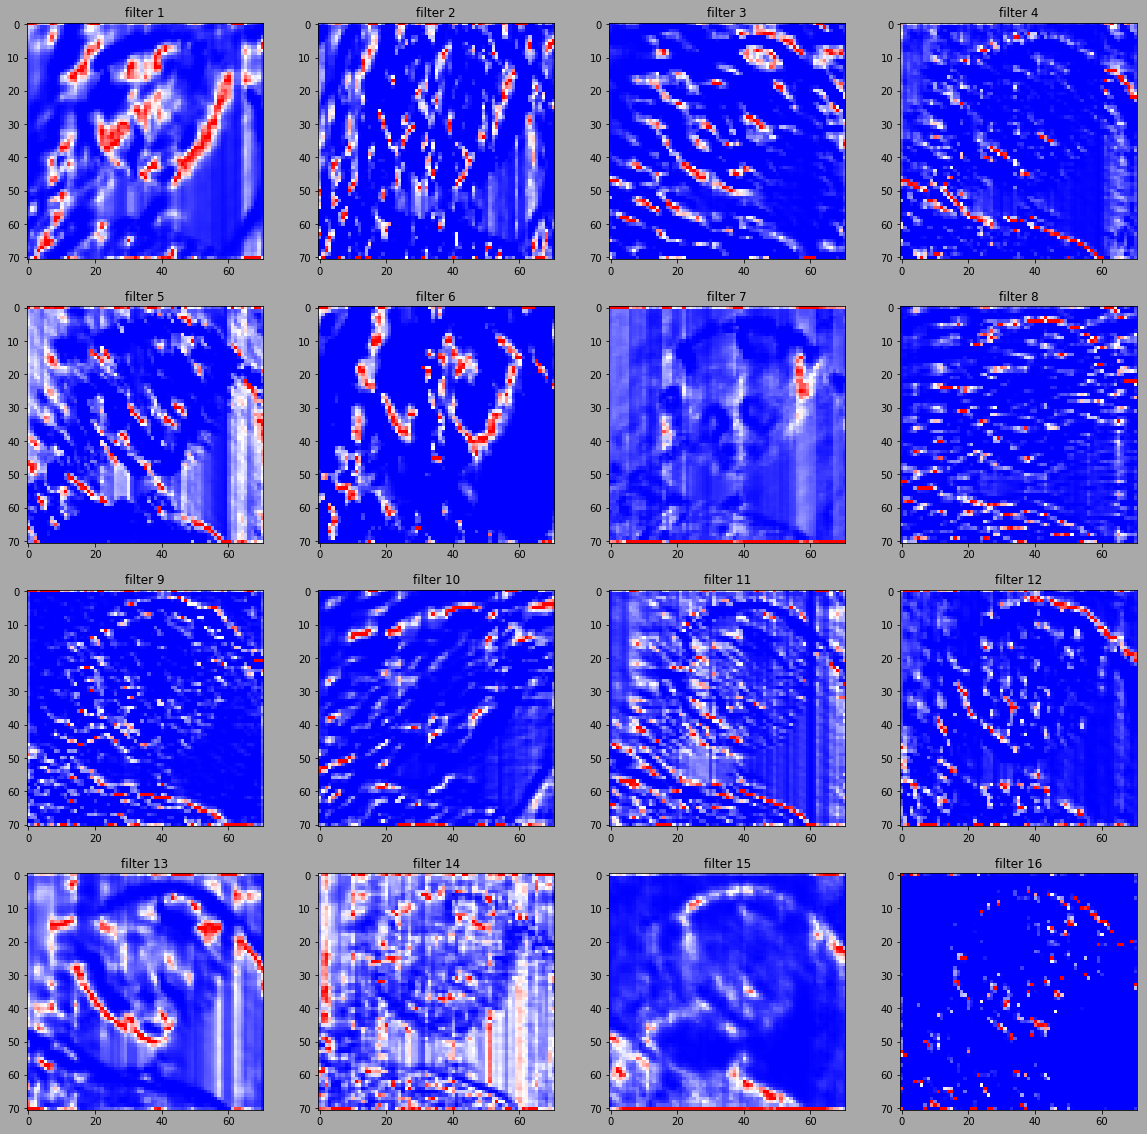

In [19]:
tf.reset_default_graph()
sess = tf.Session()

with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        net, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)
    
    # Check the above cell for other layer names
    logits = end_points['Conv2d_4a_3x3']
        # Compute feature weights
    yi = tf.nn.softmax(logits, 1)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)
    
    input_X = input_resized_img
    fm = sess.run(yi, feed_dict={X: input_X})
    visualize_feature_maps(None, None, precomputed_feature_map=fm[0], n_filters=16)

{ 'AuxLogits': <tf.Tensor 'InceptionV3/AuxLogits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
  'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
  'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
  'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
  'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
  'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
  'Logits': <tf.Tensor 'InceptionV3/Logits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
  'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
  'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) d

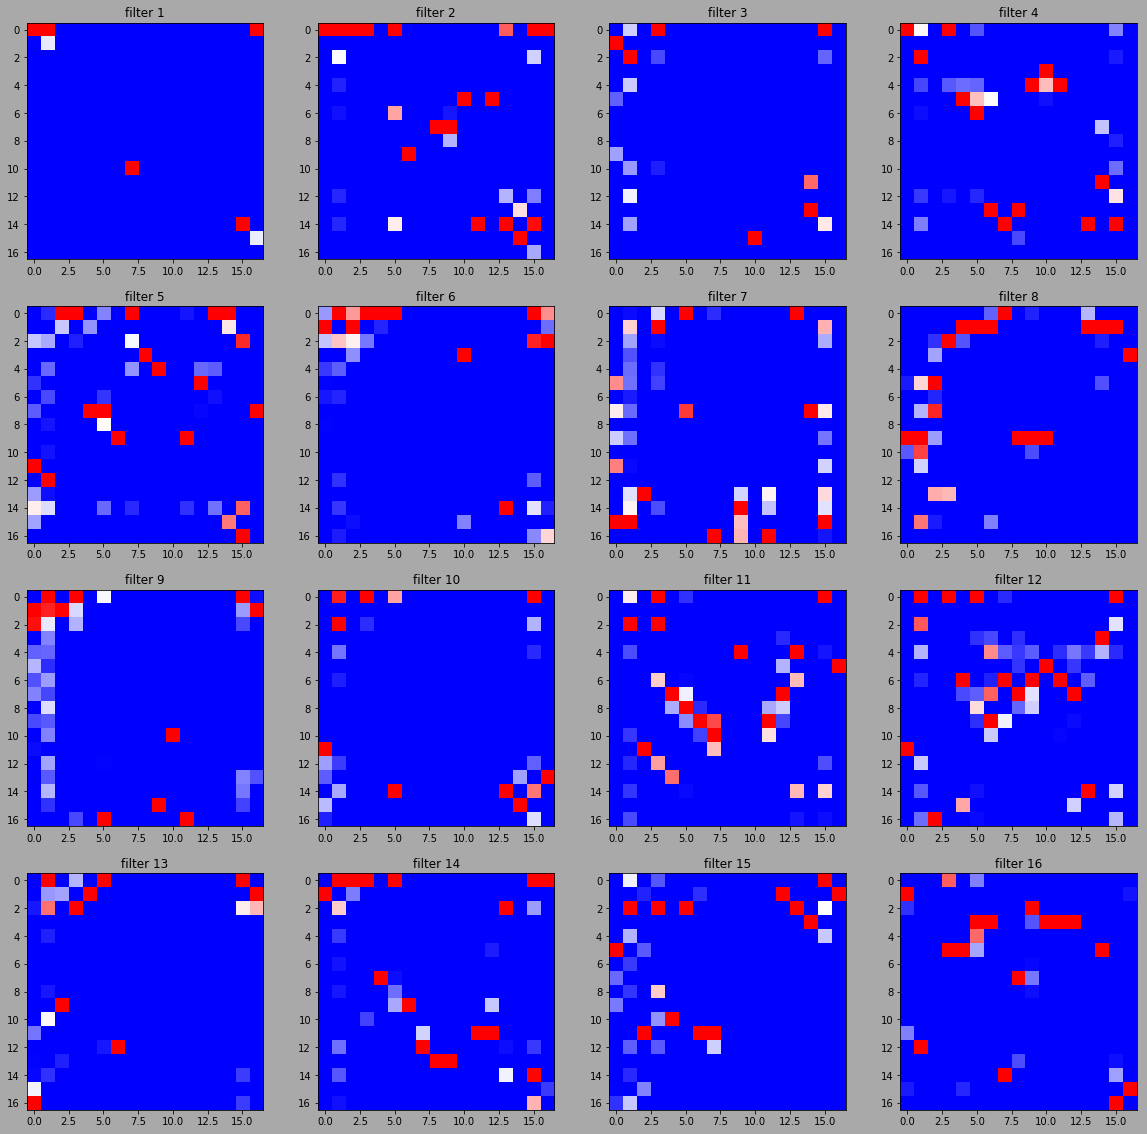

In [20]:
import pprint
tf.reset_default_graph()
sess = tf.Session()
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        net, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)
    pp = pprint.PrettyPrinter(indent=2)
    pp.pprint(end_points)
        
    
    # Check the above cell for other layer names
    logits = end_points['Mixed_6e']
    # Compute feature weights
    yi = tf.nn.softmax(logits, 1)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)
    
    input_X = input_resized_img
    fm = sess.run(yi, feed_dict={X: input_X})
    visualize_feature_maps(None, None, precomputed_feature_map=fm[0], n_filters=16)

In [11]:
from skater.util.logger import build_logger
from skater.util.logger import _INFO

with DeepInterpreter(session=sess) as de:
    de.logger = build_logger(_INFO, __name__)
    relevancy_scores = {
        'e-LRP': de.explain('elrp', tf.reduce_max(logits, 1), X, input_X, use_case="image"),
       'integrated gradient': de.explain('ig', tf.reduce_max(logits, 1), X, input_X, use_case="image"),
    }
    print ("success...")

2018-05-02 15:43:39,265 - __main__ - INFO - all supported relevancy scorers OrderedDict([('elrp', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.relevance_scorer.LRP'>}), ('ig', {'use_case_type': ['image', 'txt'], 'method': <class 'skater.core.local_interpretation.dnni.relevance_scorer.IntegratedGradients'>})])
2018-05-02 15:43:39,269 - __main__ - INFO - DeepInterpreter: executing relevance type class <class 'skater.core.local_interpretation.dnni.relevance_scorer.LRP'>
2018-05-02 15:43:39,273 - LRP - INFO - Epsilon value: 0.0001
2018-05-02 15:43:39,276 - __main__ - INFO - DeepInterpreter: executing method <skater.core.local_interpretation.dnni.relevance_scorer.LRP object at 0x7f3160a9af60>
2018-05-02 15:43:39,280 - BaseGradient - INFO - Executing operations ...
2018-05-02 15:43:43,950 - __main__ - INFO - all supported relevancy scorers OrderedDict([('elrp', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.relevan

success...


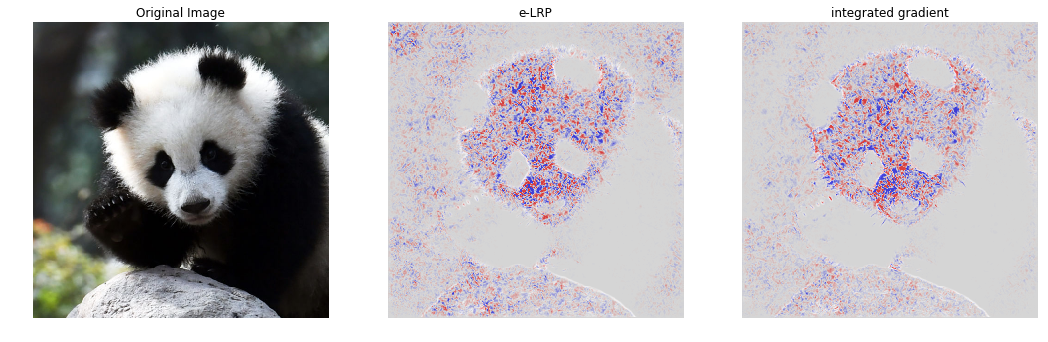

In [13]:
# Plot relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_X[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original Image')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, percentile=99, alpha=.4).set_title(r_type)

### Transforming the image to generate adversarial example

#### 1. Measuring sensitivity by flipping pixels

2018-05-02 15:45:22,194 - skater.util.image_ops - INFO - Number of pixels matching the condition : 18573
2018-05-02 15:45:22,195 - skater.util.image_ops - INFO - Number of pixels specified to be replaced : 3000


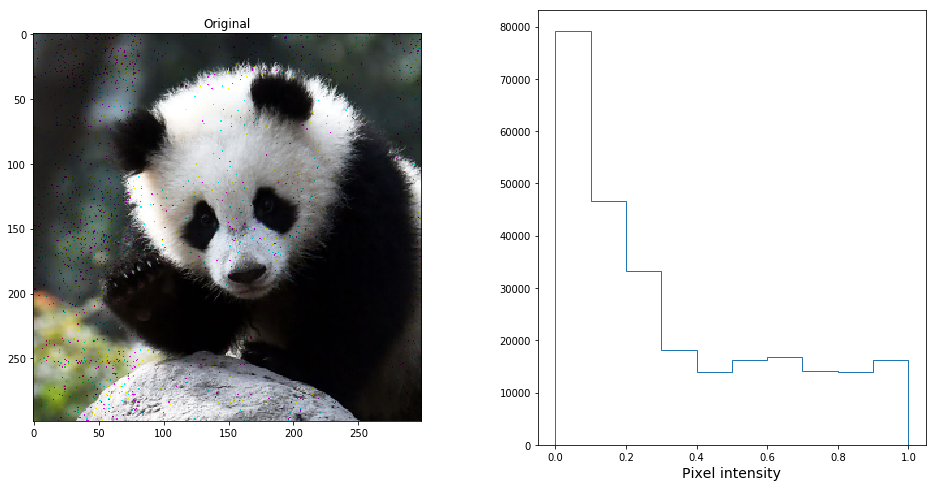

In [14]:
X = input_resized_img[0]
n_in_img = flip_pixels(X, 3000, filtered_pixel=in_between(X, 0.3, 0.4))
show_image(n_in_img)

In [15]:
input_img = normalize(n_in_img).reshape((1, 299, 299, 3))

tf.reset_default_graph()
sess = tf.Session()
# top k predictions
top_k = 3
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    # Compute class probability 
    yi = tf.nn.softmax(logits, 1)
    
    topk, idx = tf.nn.top_k(yi, k=top_k)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_img
    label_prob, index = sess.run((topk, idx), feed_dict={X: input_X})
    # Convert indexes to labels
    label_list = [labels[str(ix)] for ix in index[0]]
    d = {
        'Class Labels ': label_list,
        'Scores' : label_prob.flatten().tolist()
    }
    labels_probabiliy_df = pd.DataFrame(d)

from IPython.display import display, HTML
pd.options.display.max_colwidth = 100
display(labels_probabiliy_df)

INFO:tensorflow:Restoring parameters from ./data/models/inception_v3.ckpt


Class Labels   \
0    giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca   
1                                                          soccer ball   
2  lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens   

     Scores  
0  0.943118  
1  0.001227  
2  0.000820

In [16]:
with DeepInterpreter(session=sess) as de:
    relevancy_scores = {
       'elrp': de.explain('elrp', tf.reduce_max(logits, 1), X, input_X, use_case='image'),
       'ig': de.explain('ig', tf.reduce_max(logits, 1), X, input_X, use_case='image')
    }
    print ("success...")

2018-05-02 15:45:28,373 - LRP - INFO - Epsilon value: 0.0001
2018-05-02 15:45:28,374 - BaseGradient - INFO - Executing operations ...
2018-05-02 15:45:31,817 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrated Gradient


success...


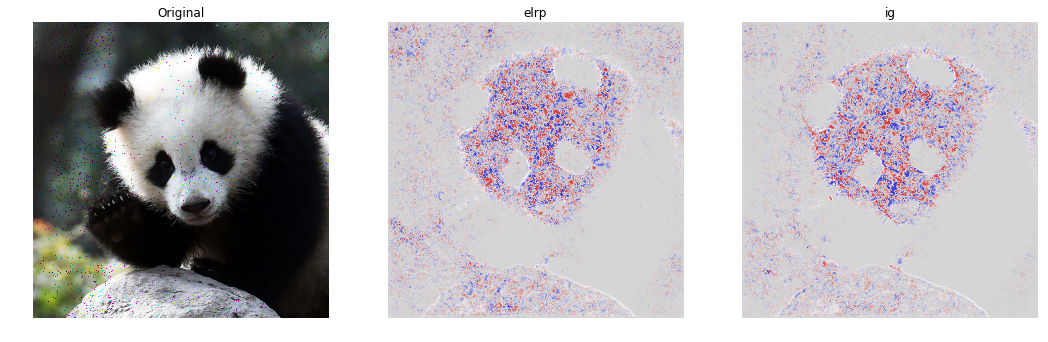

In [17]:
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_X[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, percentile=99, alpha=.4).set_title(r_type)

#### 2. By adding noise

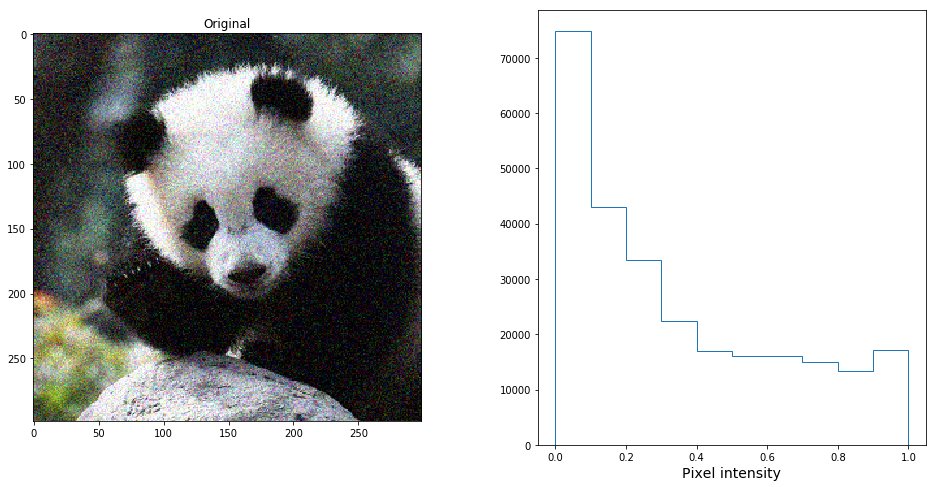

In [18]:
# a. gaussian noise
with_noise_img = add_noise(input_resized_img[0], noise_typ='gaussian', random_state=0)
show_image(with_noise_img)

#### 3. By image transformation

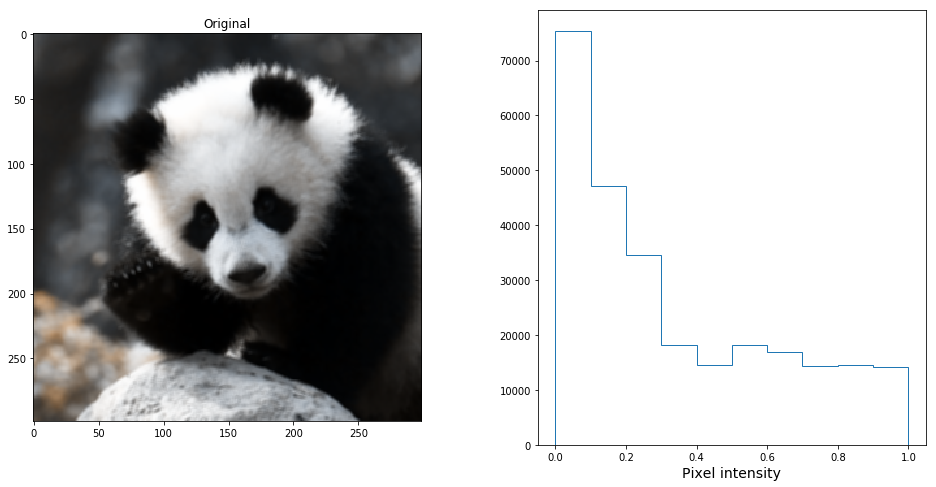

In [19]:
# 3.1. Trying blurring an image
blurred_img = image_transformation(input_resized_img[0], method_type='blur')
show_image(blurred_img)

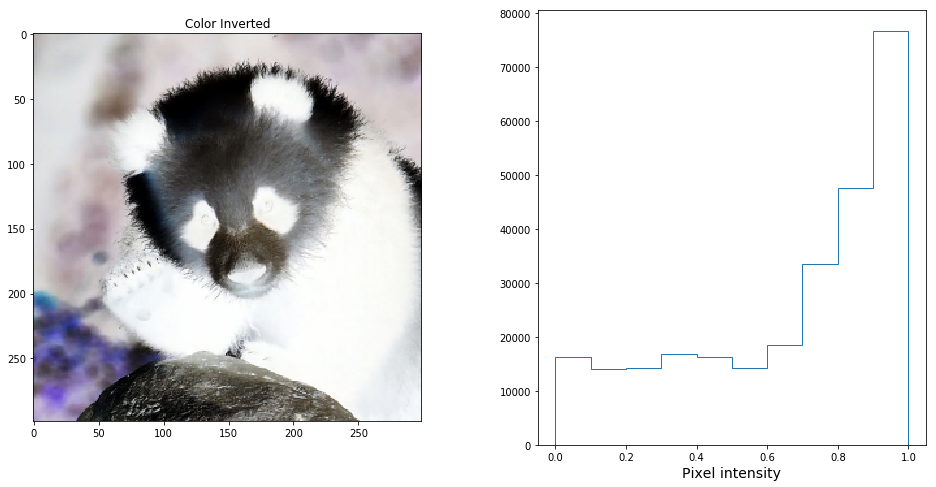

In [20]:
# 3.2 Applying color inversion
inverted_color_img = image_transformation(input_resized_img[0], method_type='invert')
show_image(inverted_color_img, title='Color Inverted')

In [23]:
input_img = normalize(inverted_color_img).reshape((1, 299, 299, 3))

tf.reset_default_graph()
sess = tf.Session()
# top k predictions
k = 3
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    # Compute class probability 
    yi = tf.nn.softmax(logits, 1)
    
    topk, idx = tf.nn.top_k(yi, k=3)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_img
    label_prob, index = sess.run((topk, idx), feed_dict={X: input_X})
    # Convert indexes to labels
    label_list = [labels[str(ix)] for ix in index[0]]
    d = {
        'Class Labels ': label_list,
        'Scores' : label_prob.flatten().tolist()
    }
    labels_probabiliy_df = pd.DataFrame(d)

from IPython.display import display, HTML
pd.options.display.max_colwidth = 100
display(labels_probabiliy_df)

INFO:tensorflow:Restoring parameters from ./data/models/inception_v3.ckpt


Class Labels     Scores
0  indri, indris, Indri indri, Indri brevicaudatus  0.266485
1                            guenon, guenon monkey  0.037744
2                          colobus, colobus monkey  0.035104

In [25]:
with DeepInterpreter(session=sess) as de:
    relevancy_scores = {
       'elrp': de.explain('elrp', tf.reduce_max(logits, 1), X, input_img, use_case='image'),
        'integrated gradient': de.explain('ig', tf.reduce_max(logits, 1), X, input_img, use_case='image'),
    }
    print ("success...")

2018-05-02 15:48:30,432 - LRP - INFO - Epsilon value: 0.0001
2018-05-02 15:48:30,433 - BaseGradient - INFO - Executing operations ...
2018-05-02 15:48:32,953 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrated Gradient


success...


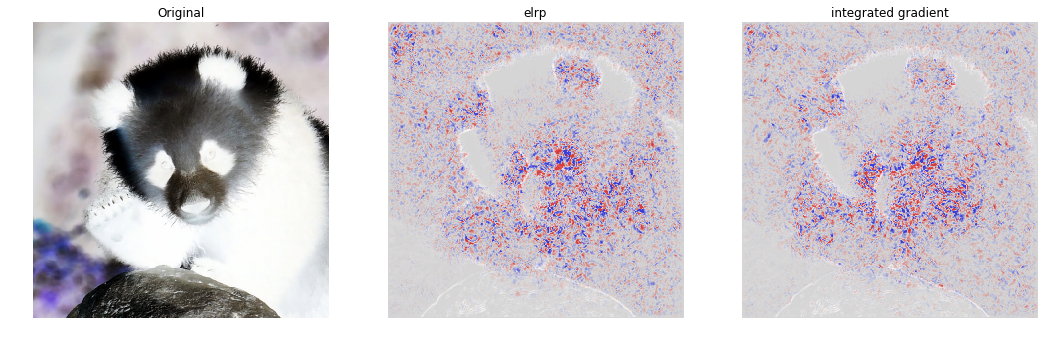

In [26]:
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_img[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, 
                  percentile=99, alpha=.4).set_title(r_type)

### More Examples

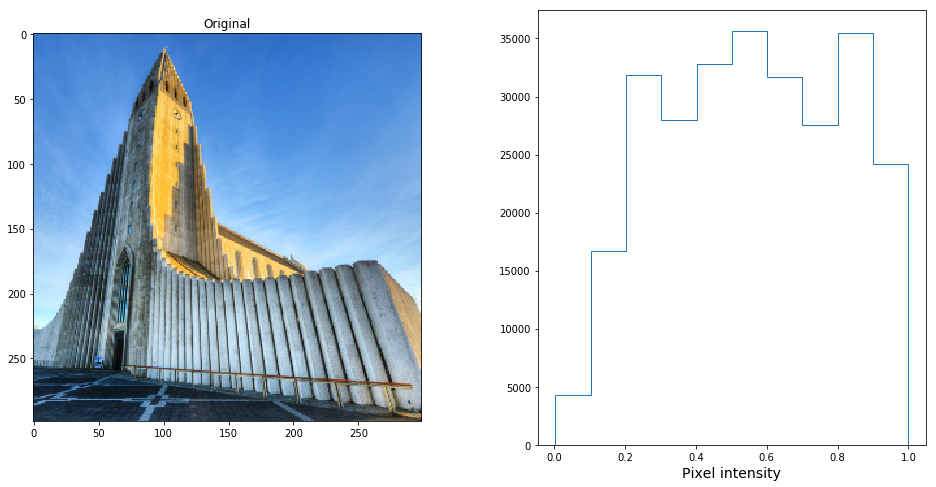

In [22]:
resized_img = load_image('./data/images/iceland_church.jpg', 299, 299)
input_resized_img = resized_img.reshape((1, 299, 299, 3))
%matplotlib inline
show_image(input_resized_img[0])

In [23]:
input_img = normalize(input_resized_img[0]).reshape((1, 299, 299, 3))

tf.reset_default_graph()
sess = tf.Session()
# top k predictions
k = 3
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    # Compute class probability 
    yi = tf.nn.softmax(logits, 1)
    
    topk, idx = tf.nn.top_k(yi, k=3)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_img
    label_prob, index = sess.run((topk, idx), feed_dict={X: input_X})
    # Convert indexes to labels
    label_list = [labels[str(ix)] for ix in index[0]]
    d = {
        'Class Labels ': label_list,
        'Scores' : label_prob.flatten().tolist()
    }
    labels_probabiliy_df = pd.DataFrame(d)

from IPython.display import display, HTML
pd.options.display.max_colwidth = 100
display(labels_probabiliy_df)

INFO:tensorflow:Restoring parameters from ./data/models/inception_v3.ckpt


Class Labels     Scores
0  church, church building  0.467225
1      bell cote, bell cot  0.061973
2                    vault  0.037967

2018-04-25 03:17:46,313 - LRP - INFO - Epsilon value: 0.0001
2018-04-25 03:17:46,314 - BaseGradient - INFO - Executing operations ...
2018-04-25 03:17:49,848 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrated Gradient


success...


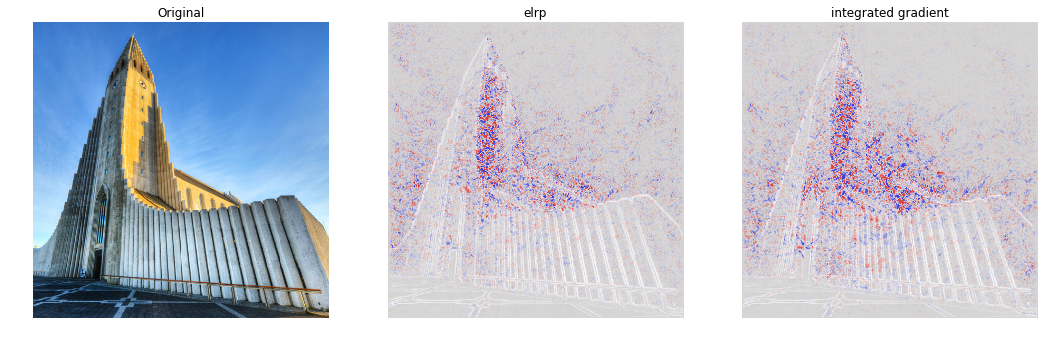

In [24]:
with DeepInterpreter(session=sess) as de:
    relevancy_scores = {
       'elrp': de.explain('elrp', tf.reduce_max(logits, 1), X, input_X, use_case='image'),
        'integrated gradient': de.explain('ig', tf.reduce_max(logits, 1), X, input_X, use_case='image'),
    }
    print ("success...")
    
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_X[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, percentile=99, alpha=.4).set_title(r_type)

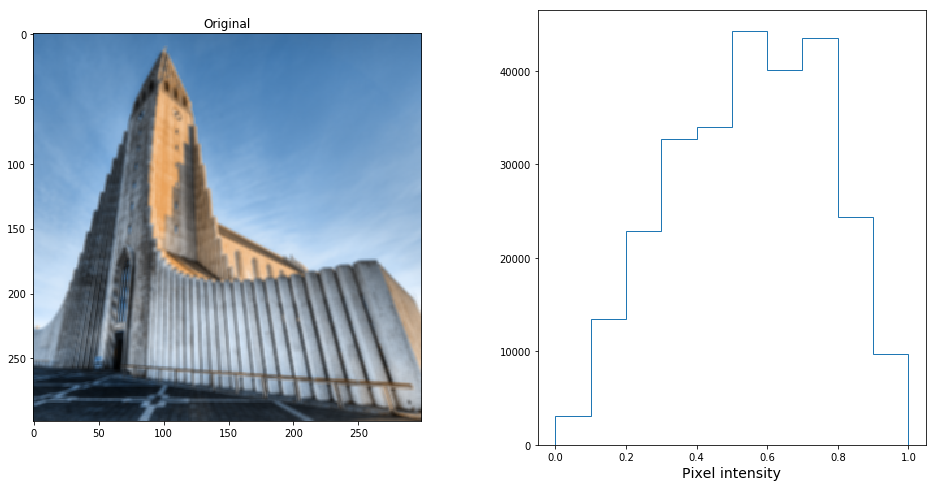

In [25]:
blurred_img = image_transformation(input_resized_img[0], method_type='blur')
show_image(blurred_img)

In [26]:
input_img = normalize(blurred_img).reshape((1, 299, 299, 3))

tf.reset_default_graph()
sess = tf.Session()
# top k predictions
k = 3
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    # Compute class probability 
    yi = tf.nn.softmax(logits, 1)
    
    topk, idx = tf.nn.top_k(yi, k=3)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_img
    label_prob, index = sess.run((topk, idx), feed_dict={X: input_X})
    # Convert indexes to labels
    label_list = [labels[str(ix)] for ix in index[0]]
    d = {
        'Class Labels ': label_list,
        'Scores' : label_prob.flatten().tolist()
    }
    labels_probabiliy_df = pd.DataFrame(d)

from IPython.display import display, HTML
pd.options.display.max_colwidth = 100
display(labels_probabiliy_df)

INFO:tensorflow:Restoring parameters from ./data/models/inception_v3.ckpt


Class Labels     Scores
0  church, church building  0.297580
1      bell cote, bell cot  0.190438
2                monastery  0.028667

2018-04-25 03:23:30,975 - LRP - INFO - Epsilon value: 0.0001
2018-04-25 03:23:30,976 - BaseGradient - INFO - Executing operations ...
2018-04-25 03:23:34,640 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrated Gradient


success...


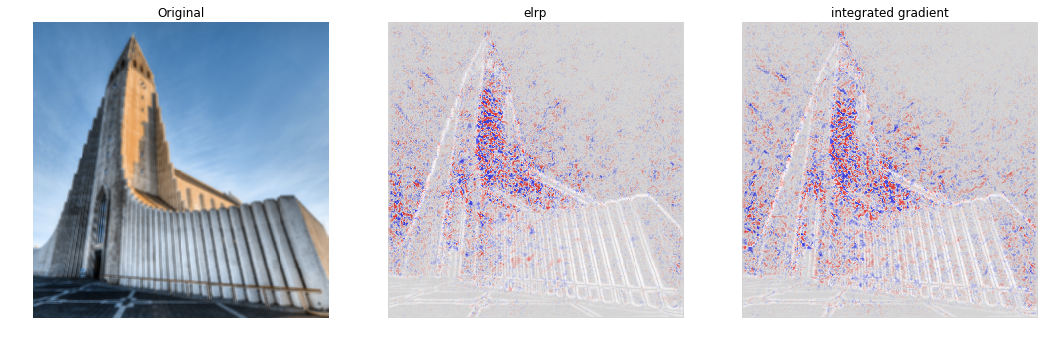

In [27]:
with DeepInterpreter(session=sess) as de:
    relevancy_scores = {
       'elrp': de.explain('elrp', tf.reduce_max(logits, 1), X, input_X, use_case='image'),
        'integrated gradient': de.explain('ig', tf.reduce_max(logits, 1), X, input_X, use_case='image'),
    }
    print ("success...")
    
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_X[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, percentile=99, alpha=.4).set_title(r_type)

#### Sensitive to white noise